In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from gensim.models import Word2Vec
import datetime
from dateutil.relativedelta import relativedelta
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

C:\Users\Lassana Diabira\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
train=pd.read_csv("Training_set.csv")

In [3]:
test=pd.read_csv("Test_set.csv")

In [4]:
train.isnull().sum()

Unnamed: 0                                  0
user_id                                     0
job_id                                      0
employer_id                                 0
job_opening_date                         4020
job_closing_date                        23311
job_description                             0
job_type                                    0
job_title                                   0
employer_title                              0
employer_description                        0
employer_sector_id                          0
employer_sector_title                       0
jobsector_id                                0
job_sector_title                            0
gender                                    601
course_includes_industrial_placement      170
graduation_year                          9241
right_to_work_uk                          170
degree_subject_id                        9465
university_id                            9268
university_name                   

In [67]:
def get_job_characteristics(df):
    job_id=[]
    employer_id=[]
    job_closing_date=[]
    job_type=[]
    employer_sector_id=[]
    jobsector_id=[]
    for i in range(df.shape[0]):
        data=df.iloc[i]
        #ids=data["job_id"]
        #em_id=data["employer_id"]
        try:
            close_date=int(data["job_closing_date"].replace("-",""))
        except:
            close_date=0
        types=data["job_type"]
        em_sector_id=data["employer_sector_id"]
        sector_id=data["jobsector_id"]
        #job_id.append(ids)
        #employer_id.append(em_id)
        job_closing_date.append(close_date)
        job_type.append(types)
        employer_sector_id.append(em_sector_id)
        jobsector_id.append(sector_id)
    max_close=max(job_closing_date)
    job_closing_date=[i/max_close for i in job_closing_date]
    return np.array([job_closing_date, job_type, employer_sector_id, jobsector_id]).T

In [68]:
job_characteristics=get_job_characteristics(train)

In [69]:
job_characteristics.shape

(125136, 4)

In [8]:
job_characteristics[1,:]

array([4.53300000e+03, 2.08000000e+02, 9.99970283e-01, 3.00000000e+00,
       9.70000000e+01, 9.70000000e+01])

In [9]:
def get_job_info(df):
    job_info=[]
    for i in range(df.shape[0]):
        data=df.iloc[i]
        title=data["job_title"]
        job_sector_title=data["job_sector_title"]
        description=data["job_description"]
        em_title=data["employer_title"]
        em_sector_title=data["employer_sector_title"]
        em_description=data["employer_description"]
        a=""
        a+=title+" "
        a+=job_sector_title+" "
        a+=description+" "
        a+=em_title+" "
        a+=em_sector_title+" "
        a+=em_description+" "
        job_info.append(a)
    return job_info

In [10]:
train_job_info=get_job_info(train)

In [11]:
def clean(x):
    res=[] 
    for content in x:
        content=content.replace("&bull;","\r\n ").replace("\r\r\n\t"," ").replace("\r\r\n"," ")
        content=content.replace("\r\r\n\r\r\n"," ").replace("..."," ").replace("&#39;s","").replace(":","")
        content=content.replace("&eacute;","e").replace("&lsquo;","").replace("&#39;","")
        content=content.replace("&nbsp;"," ").replace("&#39;","").replace("amp;","").replace("&middot;","")
        content=content.replace("."," ").replace(",","").replace("?"," ").replace("!","").replace("  "," ")
        content=content.replace("&rsquo;","").replace("\t"," ").replace("\r\n\r\n","").replace(" \r\n ","")
        content=content.replace("&ndash;"," ").replace("\r\n\r\n"," ").replace(" \r\n "," ").replace("\r\n"," ")
        content=content.replace("\r"," ").replace("  ","").replace("   ","").replace("  ","").replace("   ","")
        content=content.replace("(","").replace(")","").replace(" - "," ").replace(" / "," ").replace("/"," ").replace("   ","")
        content=re.sub('<.*?>',"",content , flags=re.DOTALL)
        content=content.split(" ")
        y=[]
        for i in content:
            if len(i)>1:
                y.append(i.lower())
        res.append(y)
    return res

In [12]:
cleaned_train_job_info=clean(train_job_info)

In [13]:
cleaned_train_job_info[100]

['graduate',
 'consultant',
 'climate',
 'change',
 'cities',
 'technology',
 'consulting',
 'project',
 'management',
 'at',
 'arup',
 'we',
 'are',
 'passionate',
 'about',
 'designing',
 'and',
 'delivering',
 'ground-breaking',
 'work',
 'in',
 'infrastructure',
 'building',
 'design',
 'and',
 'specialist',
 'technical',
 'services',
 'independent',
 'in',
 'ownership',
 'and',
 'spirit',
 'we',
 'are',
 'global',
 'firm',
 'of',
 'designers',
 'planners',
 'engineers',
 'consultants',
 'and',
 'technical',
 'experts',
 'using',
 'our',
 'skills',
 'to',
 'help',
 'shape',
 'better',
 'world',
 'our',
 'energy',
 'climate',
 'change',
 'and',
 'cities',
 'consulting',
 'team',
 'in',
 'london',
 'is',
 'multi-disciplinary',
 'team',
 'of',
 'engineers',
 'policy',
 'experts',
 'and',
 'environmental',
 'scientists',
 'who',
 'focus',
 'on',
 'the',
 'challenges',
 'and',
 'opportunities',
 'of',
 'energy',
 'climate',
 'change',
 'and',
 'cities',
 'our',
 'areas',
 'of',
 'busine

In [14]:
def remove_stopwords(x):
    res=[]
    with open('stopwords.txt') as stopfile:
        stopwords = stopfile.read()
        stop = stopwords.split()
    for i,job in enumerate(x):
        a=[]
        for word in job:
            if word not in stop:
                a.append(word)
        res.append(a)
    return res

In [15]:
train_clean=remove_stopwords(cleaned_train_job_info)

In [16]:
train_clean[0]

['uk',
 'sales',
 'graduate',
 'job',
 '2019',
 'sales',
 'commercial',
 'overview',
 'want',
 'work',
 'brands',
 'millions',
 'consumers',
 'live',
 'without',
 'want',
 'work',
 'like-minded',
 'talented',
 'colleagues',
 'motivated',
 'challenging',
 'problems',
 'real',
 'responsibility',
 'winning',
 'perfect',
 'opportunity',
 'apply',
 'now',
 'join',
 'p&g',
 'sales',
 'team',
 'expect',
 'working',
 'sales',
 'p&g',
 'means',
 'getting',
 'multi',
 'million',
 'pound',
 'business',
 'budget',
 'lead',
 'day',
 'means',
 'working',
 'great',
 'brands',
 'like',
 'pampers',
 'fairy',
 'gillette',
 'uk',
 'biggest',
 'grocery',
 'retailers',
 'will',
 'key',
 'contact',
 'business',
 'retailer',
 'responsible',
 'building',
 'maintaining',
 'relationship',
 'will',
 'build',
 'design',
 'ideas',
 'strategies',
 'using',
 'analytics',
 'shopper',
 'insights',
 'use',
 'relationship',
 'understanding',
 'market',
 'sell',
 'negotiate',
 'execute',
 'ideas',
 'full',
 'time',
 'hir

In [17]:
def get_occurence(x):
    res=[]
    for job in x:
        res.append(dict(Counter(job)))
    return res

In [18]:
occurences=get_occurence(train_clean)

In [19]:
occurences[0]

{'uk': 2,
 'sales': 8,
 'graduate': 2,
 'job': 3,
 '2019': 1,
 'commercial': 4,
 'overview': 1,
 'want': 3,
 'work': 6,
 'brands': 3,
 'millions': 1,
 'consumers': 1,
 'live': 1,
 'without': 1,
 'like-minded': 1,
 'talented': 1,
 'colleagues': 1,
 'motivated': 1,
 'challenging': 2,
 'problems': 1,
 'real': 3,
 'responsibility': 2,
 'winning': 1,
 'perfect': 1,
 'opportunity': 2,
 'apply': 3,
 'now': 1,
 'join': 1,
 'p&g': 13,
 'team': 2,
 'expect': 1,
 'working': 3,
 'means': 2,
 'getting': 1,
 'multi': 1,
 'million': 1,
 'pound': 1,
 'business': 5,
 'budget': 1,
 'lead': 1,
 'day': 4,
 'great': 2,
 'like': 1,
 'pampers': 1,
 'fairy': 2,
 'gillette': 2,
 'biggest': 1,
 'grocery': 1,
 'retailers': 1,
 'will': 6,
 'key': 1,
 'contact': 1,
 'retailer': 2,
 'responsible': 1,
 'building': 2,
 'maintaining': 1,
 'relationship': 2,
 'build': 1,
 'design': 1,
 'ideas': 3,
 'strategies': 1,
 'using': 1,
 'analytics': 1,
 'shopper': 1,
 'insights': 1,
 'use': 1,
 'understanding': 1,
 'market': 1

In [20]:
def get_vector(occurences, jobs, vector_size):
    vector=[]
    model = Word2Vec.load('model.bin')
    nb=len(jobs)
    for i,job in enumerate(jobs):
        if i%5000==0:
            print("progress : ",i/nb )
        res=np.zeros(vector_size,)
        n=sum(list(occurences[i].values()))
        for word in job:
            try:
                a=model[word]
            except:
                a=None
            if a is not None:
                count=occurences[i][word]
                w=count/n
                res+=w*a
        vector.append(res)
    return vector

In [21]:
X=get_vector(occurences, train_clean, 200)

progress :  0.0


C:\Users\Lassana Diabira\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


progress :  0.03995652729829945
progress :  0.0799130545965989
progress :  0.11986958189489835
progress :  0.1598261091931978
progress :  0.19978263649149725
progress :  0.2397391637897967
progress :  0.27969569108809617
progress :  0.3196522183863956
progress :  0.35960874568469503
progress :  0.3995652729829945
progress :  0.43952180028129395
progress :  0.4794783275795934
progress :  0.5194348548778929
progress :  0.5593913821761923
progress :  0.5993479094744918
progress :  0.6393044367727913
progress :  0.6792609640710906
progress :  0.7192174913693901
progress :  0.7591740186676895
progress :  0.799130545965989
progress :  0.8390870732642884
progress :  0.8790436005625879
progress :  0.9190001278608874
progress :  0.9589566551591868
progress :  0.9989131824574863


In [23]:
X_train=np.array(X)

In [24]:
pca = PCA(n_components=2)
result = pca.fit_transform(X_train)

In [25]:
print(pca.explained_variance_ratio_)

[0.15401265 0.11756374]


In [26]:
def get_job_info_plot(df):
    job_info=[]
    for i in range(df.shape[0]):
        data=df.iloc[i]
        title=data["job_title"]
        em_title=data["employer_title"]
        a=""
        a+=title+" "
        a+=em_title+" "
        job_info.append(a)
    return job_info

In [27]:
infos=get_job_info_plot(train)

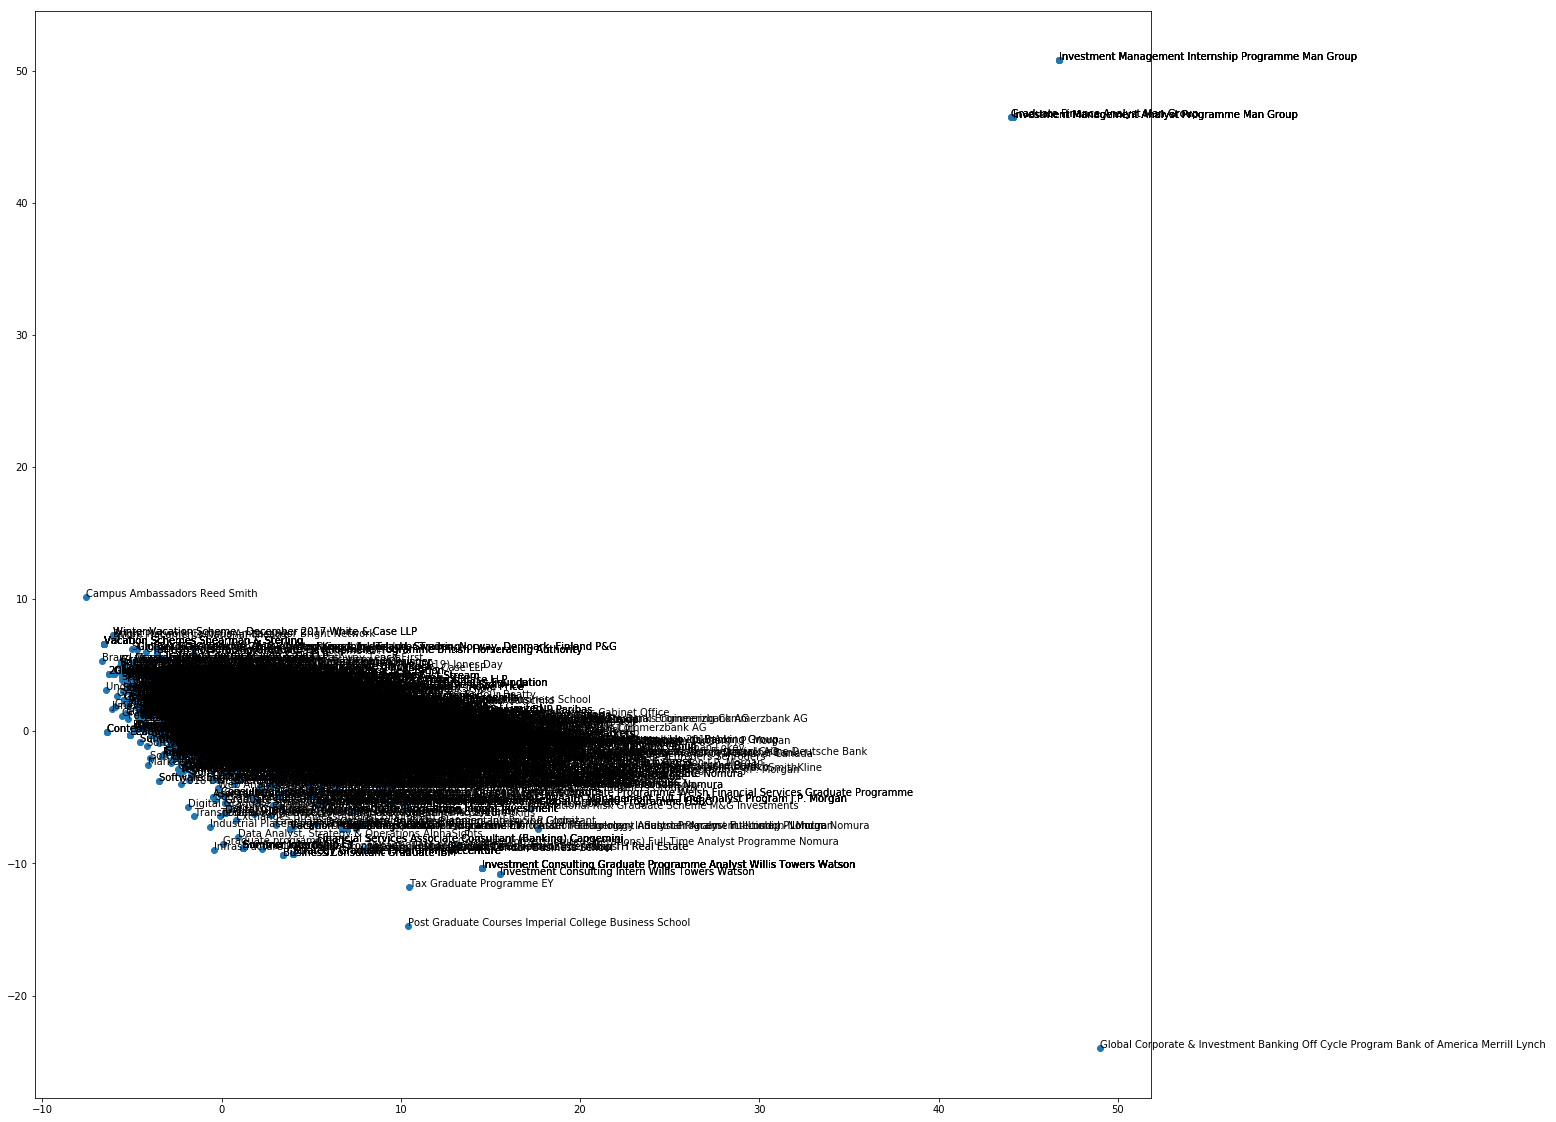

In [28]:
k=20
plt.figure(figsize=(20,20))
plt.scatter(result[:k, 0], result[:k, 1])
for i, word in enumerate(infos[:k]):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

In [29]:
list(cosine_similarity(X_train[0,:].reshape(1, -1) , X_train))[0]

array([1.        , 0.93048404, 0.98082065, ..., 0.37889678, 0.51612744,
       0.08515185])

In [30]:
def get_similar_doc(X_train, doc_id, n):
    res=[]
    beta=[]
    cos=list(cosine_similarity(X_train[doc_id,:].reshape(1, -1) , X_train))[0]
    most_similar_doc_id=np.argsort(cos)[::-1]
    a=0
    while cos[most_similar_doc_id[a]]>=0.9999999:
        a+=1
    most_similar_doc_id=most_similar_doc_id[a:]
    res.append(most_similar_doc_id[0])
    beta.append(cos[most_similar_doc_id[0]])
    for i in range(1,len(most_similar_doc_id)):
        if cos[most_similar_doc_id[i]] not in beta:
            res.append(most_similar_doc_id[i])
            beta.append(cos[most_similar_doc_id[i]])
    print("most similar doc : ", res[:n])
    print("not similar doc : ", res[-n:][::-1])

In [87]:
get_similar_doc(X_train, 5000, 5)

most similar doc :  [111058, 88574, 9701, 41300, 50374]
not similar doc :  [62222, 89471, 119665, 120738, 89090]


In [32]:
def clean_similarity(x):
    res=[] 
    for content in x:
        content=content.replace("&bull;","\r\n ").replace("\r\r\n\t"," ").replace("\r\r\n"," ")
        content=content.replace("\r\r\n\r\r\n"," ").replace("..."," ").replace("&#39;s","").replace(":","")
        content=content.replace("&eacute;","e").replace("&lsquo;","").replace("&#39;","")
        content=content.replace("&nbsp;"," ").replace("&#39;","").replace("amp;","").replace("&middot;","")
        content=content.replace("."," ").replace(",","").replace("?"," ").replace("!","").replace("  "," ")
        content=content.replace("&rsquo;","").replace("\t"," ").replace("\r\n\r\n","").replace(" \r\n ","")
        content=content.replace("&ndash;"," ").replace("\r\n\r\n"," ").replace(" \r\n "," ").replace("\r\n"," ")
        content=content.replace("\r"," ").replace("  ","").replace("   ","").replace("  ","").replace("   ","")
        content=content.replace("(","").replace(")","").replace(" - "," ").replace(" / "," ").replace("/"," ").replace("   ","")
        content=re.sub('<.*?>',"",content , flags=re.DOTALL)
        res.append(content)
    return res

In [33]:
data_similarity=clean_similarity(train_job_info)

In [88]:
data_similarity[5000]

'Trainee Recruitment Consultant Graduate Financial Services Trainee Recruitment Consultant Are you a recent graduate looking to gain real experience in a professional environment At Robert Half were currently on the lookout for ambitious and driven graduates to join our Birmingham office  For more than 65 years Robert Half has been a multi-award winning global leader within the recruitment industry With its roots beginning in the U S the company has expanded its operations to more than 20 countries worldwide with 18+ offices in the UK alone Not only have we been featured on the FTSE green listing for our ethics first values but have also been recognised as on the Sunday Times Best Companies to Work For consistent basis Consecutively featured in Fortune Magazine list of the World Most Admired Companies our name is widely-recognised and we have established relationships with UK businesses across a wide range of industries  What Robert Half will offer you  Impressive training program that

In [89]:
data_similarity[111058]

'Graduate Resourcer Consultant Consulting Overview Robert Half is currently looking to recruit a Graduate Resourcer Consultant to join their growing Permanent Services Division in Central Nottingham This is a busy exciting role which is demanding and rewarding in equal measure  Robert Half is currently looking to recruit a Graduate Resourcer Consultant to join their growing Permanent Services Division in Central Nottingham This is a busy exciting role which is demanding and rewarding in equal measure The opportunity is massive for both earning potential and career development although consistent hard work will be required to achieve these  The Role This is a broad ranging role that will see you gain an ideal entry point into a recruitment career in one of the largest professional recruitment businesses worldwide Your key responsibilities will be  Attracting and engaging candidates to Robert Half through writing job adverts social media monitoring databases and telephone work Implement 

In [91]:
data_similarity[119665]

'Data Engineer Analytics Intern Summer 2018 Technology Consulting & Project Management Overview Facebook mission is to give people the power to build community and bring the world closer together Through our family of apps and services were building a different kind of company that connects billions of people around the world gives them ways to share what matters most to them and helps bring people closer together Whether were creating new products or helping a small business expand its reach people at Facebook are builders at heart Our global teams are constantly iterating solving problems and working together to empower people around the world to build community and connect in meaningful ways Together we can help people build stronger communities &mdash; were just getting started  Would you like to work with big data Do you want to use data to influence product decisions for products being used by over half a billion people every day If yes we want to talk to you Our data warehouse t

In [43]:
X_train.shape

(125136, 200)

In [44]:
job_characteristics.shape

(125136, 6)